# Final Project: Earth Analytics Python Course, Spring 2020
## Steph Shepherd & Lauren Herwehe

In [1]:
# Import libraries
import warnings
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from geopandas import GeoSeries as gs
from shapely.geometry import Point, Polygon
import shapely.speedups
import urllib.request

import contextily as ctx
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from earthpy import clip as cl

from zipfile import ZipFile

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In [2]:
# Download Data
# Ramsar Sites
urllib.request.urlretrieve(
    "https://ndownloader.figshare.com/articles/12217679/versions/1", "12217679.zip")

with ZipFile('12217679.zip', 'r') as zipObj:
    zipObj.extractall("ramsar")

# Future dams
et.data.get_data(url="https://ndownloader.figshare.com/files/22486157")

'/home/jovyan/earth-analytics/data/earthpy-downloads/future_dams_2015.csv'

In [3]:
# Open the ramsar shapefile with geopandas
ramsar_areas = gpd.read_file(os.path.join(
    "ramsar", "features_publishedPolygon.shp"))

# Check the crs of the ramsar sites
print(ramsar_areas.crs)

# Open the dams csv files with pandas
fname = os.path.join("earthpy-downloads", "future_dams_2015.csv")
df = pd.read_csv(fname)

# Covert the pandas dataframe to a shapefile for plotting
# Set output path for shp
dams_path = os.path.join('final-project-data', 'fhred-proposed-dams')
if not os.path.exists(dams_path):
    os.mkdir(dams_path)

# Define the geometry for the points
geometry = [Point(xy) for xy in zip(df.Lon_Cleaned, df.LAT_cleaned)]
crs = {'init': 'epsg:4326'}
geo_df = gdf(df, crs=crs, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename=os.path.join(
    dams_path, 'proposed_dams.shp'))

# Open the proposed dams shapefile with geopandas
proposed_dams = gpd.read_file(os.path.join(dams_path, "proposed_dams.shp"))

# Pull only the columns that we need from each gdf to save processing time
proposed_dams = proposed_dams[['Country', 'Continent', 'Major Basi', 'Stage', 'geometry']]
ramsar_areas = ramsar_areas[['country_en', 'geometry']]

# Open country borders shapefile for adding boundary of study area
country_borders_path = os.path.join("final-project-data","country-borders",
                                  "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp")
country_borders = gpd.read_file(country_borders_path)


# Open country borders shapefile for adding boundary of study area
south_america_path = os.path.join("final-project-data","south-america",
                                  "vc965bq8111.shp")
south_america = gpd.read_file(south_america_path)

epsg:4326


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
# Getting Number of Dams by Continent and Development State
# Extact the columns needed for analysis
dams_continent = proposed_dams[['Continent', 'Country', 'Stage']]

# Group and count data by stage.
dams_stage = dams_continent.groupby(['Continent','Country','Stage'])[['Stage']].count()

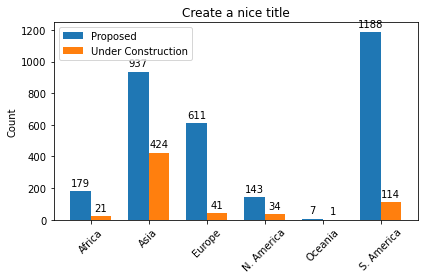

In [5]:
# PLOT - NUMBER OF DAMS PROPOSED VS UNDER CONSTRUCTION BY CONTINENT
# Create a bar plot of the dams by continent and stage of process.
labels = ['Africa', 'Asia', 'Europe', 'N. America', 'Oceania', 'S. America']
proposed = [179, 937, 611, 143, 7, 1188]
under_const = [21, 424, 41, 34, 1, 114]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, under_const, width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Create a nice title')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its value."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [6]:
# Analyze Guinea
# Change the CRS to meters for Guinea
proposed_dams_guin = proposed_dams.to_crs('epsg:3395')
ramsar_areas_guin = ramsar_areas.to_crs('epsg:3395')

# Pull only the data for Guinea
proposed_dams_guin = proposed_dams_guin[proposed_dams_guin['Country'] == "Guinea"]
ramsar_areas_guin = ramsar_areas_guin[ramsar_areas_guin['country_en'] == "Guinea"]

# Buffer the dams to 5km & 10km for plotting
proposed_dams_guin_5k_buff = proposed_dams_guin.buffer(5000)
proposed_dams_guin_10k_buff = proposed_dams_guin.buffer(10000)

# # NOT WORKING - MAKING BUFFERS THEIR OWN COLUMNS SO AS NOT TO KEEP MAKING ORIGINAL POINT GEOMETRY LARGER EVERY TIME WE BUFFER
# # Buffer the dams to 5km, set it as the geometry for the overlay, and create geodataframe of intersections
# proposed_dams_guin['geom_5k_buff']= proposed_dams_guin.buffer(5000)
# proposed_dams_guin.set_geometry('geom_5k_buff')
# data_intersect_5k_guin = gpd.overlay(ramsar_areas_guin, proposed_dams_guin, how='intersection')

# # Buffer the dams to 10km, set it as the geometry for the overlay, and create geodataframe of intersections
# proposed_dams_guin['geom_10k_buff']= proposed_dams_guin.buffer(10000)
# proposed_dams_guin.set_geometry('geom_10k_buff')
# data_intersect_10k_guin = gpd.overlay(ramsar_areas_guin, proposed_dams_guin, how='intersection')


In [8]:
# Get border of Guinea and reproject
guinea_border = country_borders[country_borders['CNTRY_NAME'] == "Guinea"]
guinea_border = guinea_border.to_crs('epsg:3395')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


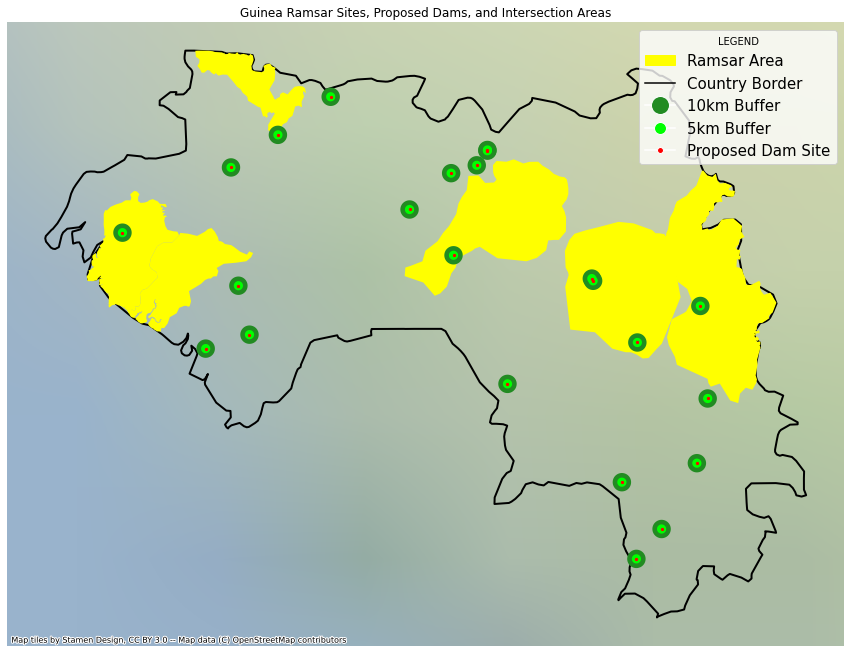

In [9]:
# Create a map of the dams and the ramsar sites for Guinea
# Creating a legend very manually bc can't get it to work any other way
yellow_patch = mpatches.Patch(color='yellow', label='Ramsar Area')
black_line = mlines.Line2D([], [], color='black', label='Country Border')
green_circle= mlines.Line2D([], [], color='white', marker='o', markerfacecolor='forestgreen', markersize=18, label='10km Buffer')
lime_circle= mlines.Line2D([], [], color='white', marker='o', markerfacecolor='lime', markersize=12, label='5km Buffer')
red_dot= mlines.Line2D([], [], color='white', marker='o', markerfacecolor='red', label='Proposed Dam Site')

fig, ax = plt.subplots(figsize=(15, 15))
guinea_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
ramsar_areas_guin.plot(ax=ax, facecolor = 'yellow')
proposed_dams_guin_10k_buff.plot(facecolor='forestgreen',
    ax=ax)
proposed_dams_guin_5k_buff.plot(facecolor='lime',
    ax=ax)
proposed_dams_guin.plot(ax=ax,
                         markersize=5,
                         color='red')
ax.legend(handles=[yellow_patch, black_line, green_circle, lime_circle, red_dot],
          fontsize=15,
          frameon=True,
          loc=('upper right'),
          title="LEGEND")
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
ax.set(title='Guinea Ramsar Sites, Proposed Dams, and Intersection Areas')
ax.set_axis_off()

In [10]:
# PROBLEM - EVERY TIME YOU RUN THIS CODE IT BUFFERS UPON THE BUFFER, SO THE BUFFERS JUST GROW AND GROW!!!!
# Calculate the total area of buffers that overlaps ramsar sites for Guinea
# Buffer the dams to 5km
proposed_dams_guin['geometry']= proposed_dams_guin.buffer(5000)

# Create a geodataframe of only the intersections
data_intersect_5k_guin = gpd.overlay(ramsar_areas_guin, proposed_dams_guin, how='intersection')

# Buffer the dams to 10km, by adding another 5km buffer
proposed_dams_guin['geometry']= proposed_dams_guin.buffer(5000)

# Create a geodataframe of only the intersections
data_intersect_10k_guin = gpd.overlay(ramsar_areas_guin, proposed_dams_guin, how='intersection')

In [11]:
# Get the total sum of the intersection area for each in sq km (divide by 1 million because it sq km)
area_impacted_5k_guin = (data_intersect_5k_guin.area.sum())/1000000
area_impacted_10k_guin = (data_intersect_10k_guin.area.sum())/1000000
total_ramsar_areas_guin = (ramsar_areas_guin.area.sum())/1000000

print(area_impacted_5k_guin)
print(area_impacted_10k_guin)
print(total_ramsar_areas_guin)

479.4396524918822
1933.187789393389
61363.65430360582


In [ ]:
# POTENTIAL FUNCTIONS
# Input - country/river basin/continent name, Output - area of overlap, # of dams that overlap
# Then i can do each country in south america with the function and plot the area affected by country

# PLOT - TOTAL AREA IMPACTED PER REGION (continent, country, river basin)

In [ ]:
# # NOT WORKING - INTERSECT TO SEE HOW MANY PROPOSED DAMS OVERLAP WITH RAMSAR SITES FOR COUNTY/CONTINENT/RIVER BASIN
# # Choose study area - see how many dams overlap with ramsar areas & choose the country with the most overlaps for study area
# dam_mask = proposed_dams.intersects(ramsar_areas)
# dam_mask.value_counts()

In [ ]:
# # NOT WORKING - TOO SLOW/TOO MUCH DATA - DOING THE BUFFER & OVERLAY PROCESS FOR ALL OF SOUTH AMERICA
# # Attempting the buffers for South America
# # Change the CRS to meters for South America (chose Brazil's EPSG)
# proposed_dams_sa = proposed_dams.to_crs('epsg:5641')
# ramsar_areas_sa = ramsar_areas.to_crs('epsg:5641')
# south_america = south_america.to_crs('epsg:5641')

# # Clip the data to South America
# proposed_dams_sa = gpd.clip(proposed_dams_sa, south_america)
# ramsar_areas_sa= gpd.clip(ramsar_areas_sa, south_america)

# # Buffer the dams to 5km & 10km for plotting
# proposed_dams_sa_5k_buff = proposed_dams_sa.buffer(.001)
# proposed_dams_sa_10k_buff = proposed_dams_sa.buffer(.001)

# # Create a map of the dams and the ramsar sites for Guinea
# # Creating a legend very manually bc can't get it to work any other way
# yellow_patch = mpatches.Patch(color='yellow', label='Ramsar Area')
# black_line = mlines.Line2D([], [], color='black', label='Country Border')
# green_circle= mlines.Line2D([], [], color='white', marker='o', markerfacecolor='forestgreen', markersize=18, label='10km Buffer')
# lime_circle= mlines.Line2D([], [], color='white', marker='o', markerfacecolor='lime', markersize=12, label='5km Buffer')
# red_dot= mlines.Line2D([], [], color='white', marker='o', markerfacecolor='red', label='Proposed Dam Site')

# fig, ax = plt.subplots(figsize=(15, 15))
# ramsar_areas_sa.plot(ax=ax, facecolor = 'yellow')
# proposed_dams_sa_10k_buff.plot(facecolor='forestgreen',
#     ax=ax)
# proposed_dams_sa_5k_buff.plot(facecolor='lime',
#     ax=ax)
# proposed_dams_sa.plot(ax=ax,
#                          markersize=5,
#                          color='red')
# ax.legend(handles=[yellow_patch, black_line, green_circle, lime_circle, red_dot],
#           fontsize=15,
#           frameon=True,
#           loc=('upper right'),
#           title="LEGEND")
# ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
# ax.set(title='South America Ramsar Sites, Proposed Dams, and Intersection Areas')
# ax.set_axis_off()

# # PROBLEM - EVERY TIME YOU RUN THIS CODE IT BUFFERS UPON THE BUFFER, SO THE BUFFERS JUST GROW AND GROW!!!!
# # Calculate the total area of buffers that overlaps ramsar sites for Guinea
# # Buffer the dams to 5km
# proposed_dams_sa['geometry']= proposed_dams_sa.buffer(5000)

# # Create a geodataframe of only the intersections
# data_intersect_5k_sa = gpd.overlay(ramsar_areas_sa, proposed_dams_sa, how='intersection')

# # Buffer the dams to 10km, by adding another 5km buffer
# proposed_dams_sa['geometry']= proposed_dams_sa.buffer(5000)

# # Create a geodataframe of only the intersections
# data_intersect_10k_sa = gpd.overlay(ramsar_areas_sa, proposed_dams_sa, how='intersection')

# # Get the total sum of the intersection area for each in sq km (divide by 1 million because it sq km)
# area_impacted_5k_sa = (data_intersect_5k_sa.area.sum())/1000000
# area_impacted_10k_sa = (data_intersect_10k_sa.area.sum())/1000000
# total_ramsar_areas_sa = (ramsar_areas_sa.area.sum())/1000000

# print(area_impacted_5k_sa)
# print(area_impacted_10k_sa)
# print(total_ramsar_areas_sa)
